The goal of this project is to predict whether a tweet is announcing a disaster using NLP and Deep Learning. The dataset comes from this [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started).

# Import libraries

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from zipfile import ZipFile
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import spacy
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout, Bidirectional, SpatialDropout1D
import json
import re
from sklearn.metrics import confusion_matrix

In [2]:
sns.set_style("darkgrid")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/marion/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# EDA
## Basic statistics

There are 7613 rows in the train set and 3263 rows in the test set. 

In [3]:
tweets_zip = ZipFile('nlp-getting-started.zip', 'r')
tweets_zip.extractall('data')

In [209]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [192]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [145]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7547 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7547 non-null   int64 
 1   keyword       7490 non-null   object
 2   location      5048 non-null   object
 3   text          7547 non-null   object
 4   target        7547 non-null   int64 
 5   text_clean    7547 non-null   object
 6   text_encoded  7547 non-null   object
 7   len_text      7547 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 530.6+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [158]:
def missing_values(dataset):
    perc_missing = dataset.isnull().sum() * 100 / dataset.shape[0]
    perc_missing_df = pd.DataFrame({'feature' :perc_missing.index, 'perc_missing': perc_missing}).reset_index(drop=True)
    perc_missing_df.sort_values(by='perc_missing', ascending=False, inplace=True)
    return perc_missing_df 


perc_missing_df = missing_values(pd.concat([train.iloc[:, :-1], test]))
perc_missing_df

,feature,perc_missing
2,location,33.449798
1,keyword,0.799926
0,id,0.000000
3,text,0.000000


In [210]:
train.drop(columns=['location', 'id', 'keyword'], inplace=True)
test.drop(columns=['location', 'id', 'keyword'], inplace=True)

## Target distribution

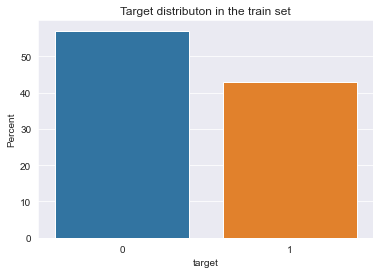

In [10]:
ax = sns.barplot(x='target', y='target', data=train, estimator=lambda x: len(x) / len(train) * 100)
ax.set(ylabel='Percent', title='Target distributon in the train set');

## Words and sentences analysis

In [270]:
tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

In [14]:
train['count_sentences'] = train['text'].apply(lambda x : len(sent_tokenize(x)))
train['count_words'] = train['text'].apply(lambda x : len(word_tokenize(x)))
train.head(10)

,id,text,target,count_sentences,count_words
0,1,Our Deeds are the Reason of this #earthquake M...,1,1,14
1,4,Forest fire near La Ronge Sask. Canada,1,2,8
2,5,All residents asked to 'shelter in place' are ...,1,2,24
3,6,"13,000 people receive #wildfires evacuation or...",1,1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,1,18
5,8,#RockyFire Update => California Hwy. 20 closed...,1,2,23
6,10,#flood #disaster Heavy rain causes flash flood...,1,1,17
7,13,I'm on top of the hill and I can see a fire in...,1,1,17
8,14,There's an emergency evacuation happening now ...,1,1,13
9,15,I'm afraid that the tornado is coming to our a...,1,1,12


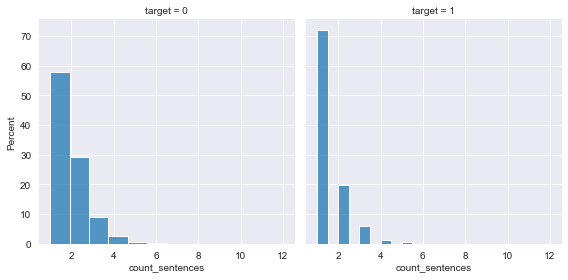

In [15]:
g = sns.FacetGrid(train, col='target', height=4)
g.map(sns.histplot,'count_sentences', bins=12, stat='percent')

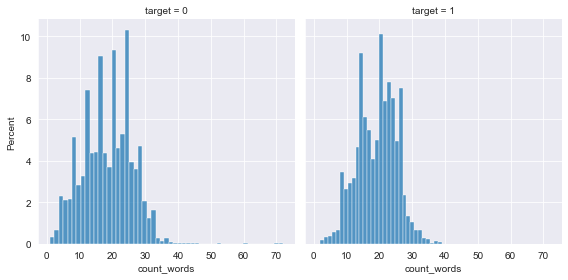

In [16]:
g = sns.FacetGrid(train, col='target', height=4)
g.map(sns.histplot,'count_words', stat='percent')

In [17]:
train_disasters = train[train['target'] == 1]
train_not_disasters = train[train['target'] == 0]

print('For distaster tweets:')
print(f'The mean number of sentences is {round(train_disasters["count_sentences"].mean(),2)} and the median is {train_disasters["count_sentences"].median()}')
print(f'The mean number of words is {round(train_disasters["count_words"].mean(),2)} and the median is {train_disasters["count_words"].median()}')

print('For non distaster tweets:')
print(f'The mean number of sentences is {round(train_not_disasters["count_sentences"].mean(),2)} and the median is {train_not_disasters["count_sentences"].median()}')
print(f'The mean number of words is {round(train_not_disasters["count_words"].mean(),2)} and the median is {train_not_disasters["count_words"].median()}')

For distaster tweets:
The mean number of sentences is 1.4 and the median is 1.0
The mean number of words is 19.26 and the median is 20.0
For non distaster tweets:
The mean number of sentences is 1.6 and the median is 1.0
The mean number of words is 18.66 and the median is 19.0


Disaster tweets are slightly longer

# Preprocessing
The first preprocessing step will :
- Remove URLs
- Remove user mention @username
- Remove non alphanumeric characters
- Lowercase
- Remove extra whitespace
- Remove stop words
- Keep only the lemma of the words

In [4]:
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import TweetTokenizer

In [5]:
def preprocess(text):
    text = re.sub('(http|https|ftp)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = ''.join(ch for ch in text if ch.isalnum() or ch==' ')
    text = text.lower().strip()
    text = ' '.join([token.lemma_ for token in nlp(text) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    return text

In [207]:
train

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,Police investigating after an e-bike collided ...,1


In [6]:
train['text_clean'] = train['text'].apply(lambda x: preprocess(x))
test['text_clean'] = test['text'].apply(lambda x: preprocess(x))

The second preprocessing step will :
- Tokenize the tweets and only keep the 1000 most commons word
- Convert to sequence
- Padding = Add 0 at the end of a sequence to make the input vectors the same size
- Convert to tensor slice
- Split train and validation test

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(train['text_clean'])
train['text_encoded'] = tokenizer.texts_to_sequences(train['text_clean'])
test['text_encoded'] = tokenizer.texts_to_sequences(test['text_clean'])
train['len_text'] = train['text_encoded'].apply(lambda x: len(x))
train = train[train['len_text']!=0]

In [8]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(train['text_encoded'], padding="post")
text_pad

array([[408, 169,   0, ...,   0,   0,   0],
       [117,   2, 159, ...,   0,   0,   0],
       [441, 320, 290, ...,   0,   0,   0],
       ...,
       [437,   5, 389, ...,   0,   0,   0],
       [ 23, 734,  88, ...,   0,   0,   0],
       [107,  25, 357, ...,   0,   0,   0]], dtype=int32)

In [9]:
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, train['target']))

Metal device set to: Apple M1


2022-11-17 14:42:44.289144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 14:42:44.289232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [55]:
# Train Test Split
TAKE_SIZE = int(0.7*train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(100)

val_data = full_ds.skip(TAKE_SIZE)
val_data = val_data.batch(100)

In [35]:
for tweet, target in train_data_batch.take(1):
    print(tweet, target)

tf.Tensor(
[[  5 412  84 ...   0   0   0]
 [430  63  28 ...   0   0   0]
 [ 82   2 234 ...   0   0   0]
 ...
 [828  51 489 ...   0   0   0]
 [429 456 468 ...   0   0   0]
 [577 609  31 ...   0   0   0]], shape=(100, 18), dtype=int32) tf.Tensor(
[1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0], shape=(100,), dtype=int64)


# Model selection
We will start by creating the simpleRNN model that will be used as a baseline. Then we will try to see if GRU and LSTM work better on our dataset. From that, we will select the best model and try to improve it by tuning the hyperparameters and changing the network architecture

## Baseline - SimpleRNN 
### Model

In [12]:
vocab_size = tokenizer.num_words 

In [335]:
model_srnn_baseline = tf.keras.Sequential([       
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  SimpleRNN(units=16, return_sequences=False), # returns the last output
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [336]:
model_srnn_baseline.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 simple_rnn_48 (SimpleRNN)   (None, 16)                784       
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_75 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32,801
Trainable params: 32,801
Non-trainable params: 0
_________________________________________________________________


In [337]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_srnn_baseline.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [13]:
weights = 1/(train['target']).value_counts()
weights = weights * len(train)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.8789890519450269, 1: 1.1596496619545174}

In [339]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_srnn_baseline.fit(train_data_batch, epochs=20, validation_data=val_data_batch, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 16:19:22.573331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5409

2022-11-16 16:19:39.950744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 20s 335ms/step - loss: 0.6946 - accuracy: 0.5409 - val_loss: 0.6894 - val_accuracy: 0.5656
Epoch 2/20
53/53 [==============================] - 12s 226ms/step - loss: 0.6856 - accuracy: 0.5693 - val_loss: 0.6860 - val_accuracy: 0.5753
Epoch 3/20
53/53 [==============================] - 12s 219ms/step - loss: 0.6787 - accuracy: 0.6030 - val_loss: 0.6837 - val_accuracy: 0.5801
Epoch 4/20
53/53 [==============================] - 12s 220ms/step - loss: 0.6650 - accuracy: 0.6454 - val_loss: 0.6711 - val_accuracy: 0.6057
Epoch 5/20
53/53 [==============================] - 11s 212ms/step - loss: 0.6349 - accuracy: 0.6924 - val_loss: 0.6491 - val_accuracy: 0.6402
Epoch 6/20
53/53 [==============================] - 12s 221ms/step - loss: 0.5849 - accuracy: 0.7336 - val_loss: 0.6247 - val_accuracy: 0.6658
Epoch 7/20
53/53 [==============================] - 12s 221ms/step - loss: 0.5293 - accuracy: 0.7741 - val_loss: 0.6132 - val_accuracy: 0.6706
Epoch 8/20

In [341]:
model_srnn_baseline.save('models/model_simpleRNN_baseline.h5')
json.dump(model_srnn_baseline.history.history, open('models/simpleRNN_baseline_history.json', 'w'))

### Evaluation

As we can see, the simpleRNN model does not seem to do a very good job. The accuracy on the validation set is only 0.68 after 10 epochs while the accuracy on the train set is 0.84. The plots above shows that the model starts overfitting from the 3rd epoch. 

In [342]:
simpleRNN_baseline_history = json.load(open('models/simpleRNN_baseline_history.json', 'r'))

In [14]:
def plot_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    x_lim = len(history['loss']) + 1

    # legend 
    train_line = mlines.Line2D([], [], color='blue', label='Train set')
    val_line = mlines.Line2D([], [], color='red', label='Validation set')

    # Loss
    sns.lineplot(x = range(1,x_lim), y=history['loss'], ax=axes[0], color='blue')
    sns.lineplot(x = range(1,x_lim), y=history['val_loss'], ax=axes[0], color='red')
    axes[0].legend(handles=[train_line, val_line], loc='upper left')
    axes[0].set(xlabel='Epochs', title='Loss')
    axes[0].set_xticks(range(x_lim), labels=range(0,x_lim))

    # Accuracy
    sns.lineplot(x = range(1,x_lim), y=history['accuracy'], ax=axes[1], color='blue')
    sns.lineplot(x = range(1,x_lim), y=history['val_accuracy'], ax=axes[1], color='red')
    axes[1].legend(handles=[train_line, val_line], loc='upper left')
    axes[1].set(xlabel='Epochs', title='Accuracy')
    axes[1].set_xticks(range(x_lim), labels=range(0,x_lim));


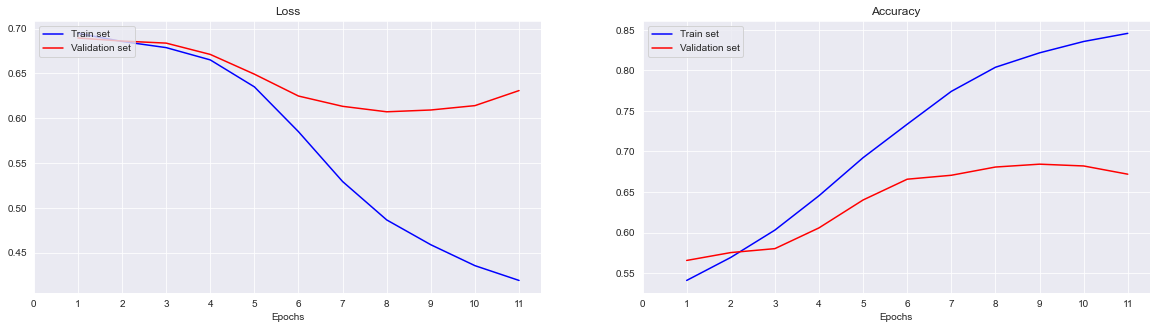

In [344]:
plot_history(simpleRNN_baseline_history)

## GRU
### Model

In [348]:
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  GRU(units=16, return_sequences=False), # returns the last output
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [349]:
model_gru.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 34,417
Trainable params: 34,417
Non-trainable params: 0
_________________________________________________________________


In [355]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [356]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_gru.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-16 20:58:03.865299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:58:04.145904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:58:05.351110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8444

2022-11-16 20:58:12.087063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:58:12.209017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 10s 145ms/step - loss: 0.3801 - accuracy: 0.8444 - val_loss: 0.5643 - val_accuracy: 0.7214
Epoch 2/20
53/53 [==============================] - 4s 66ms/step - loss: 0.3750 - accuracy: 0.8482 - val_loss: 0.5751 - val_accuracy: 0.7135
Epoch 3/20
53/53 [==============================] - 3s 49ms/step - loss: 0.3733 - accuracy: 0.8501 - val_loss: 0.5775 - val_accuracy: 0.7152
Epoch 4/20
53/53 [==============================] - 2s 38ms/step - loss: 0.3717 - accuracy: 0.8478 - val_loss: 0.5747 - val_accuracy: 0.7188


In [359]:
model_gru.save('models/model_GRU.h5')
json.dump(model_gru.history.history, open('models/GRU_history.json', 'w'))

### Evaluation

GRU does not work better than SimpleRNN

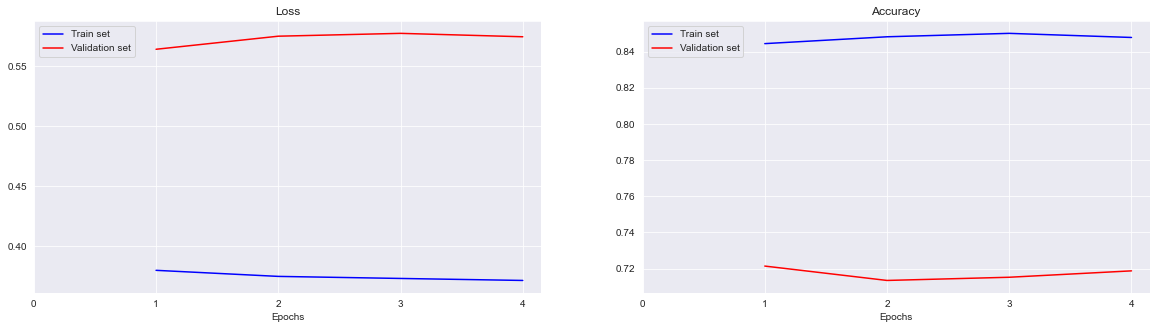

In [361]:
GRU_history = json.load(open('models/GRU_history.json', 'r'))
plot_history(GRU_history)

## LSTM
### Model

In [15]:
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  LSTM(units=16, return_sequences=False), # returns the last output
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

In [16]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 35,153
Trainable params: 35,153
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_lstm.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-17 14:07:21.975079: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 14:07:22.744060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:07:22.877504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/53 [=>............................] - ETA: 1s - loss: 0.6952 - accuracy: 0.5425  

2022-11-17 14:07:23.040178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5470

2022-11-17 14:07:24.369797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:07:24.418304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 3s 28ms/step - loss: 0.6920 - accuracy: 0.5470 - val_loss: 0.6921 - val_accuracy: 0.5558
Epoch 2/20
53/53 [==============================] - 1s 18ms/step - loss: 0.6918 - accuracy: 0.5685 - val_loss: 0.6914 - val_accuracy: 0.5563
Epoch 3/20
53/53 [==============================] - 1s 18ms/step - loss: 0.6915 - accuracy: 0.5736 - val_loss: 0.6906 - val_accuracy: 0.5563
Epoch 4/20
53/53 [==============================] - 1s 18ms/step - loss: 0.6908 - accuracy: 0.5801 - val_loss: 0.6899 - val_accuracy: 0.5567
Epoch 5/20
53/53 [==============================] - 1s 18ms/step - loss: 0.6896 - accuracy: 0.6000 - val_loss: 0.6879 - val_accuracy: 0.5620
Epoch 6/20
53/53 [==============================] - 1s 17ms/step - loss: 0.6861 - accuracy: 0.6231 - val_loss: 0.6824 - val_accuracy: 0.6177
Epoch 7/20
53/53 [==============================] - 1s 17ms/step - loss: 0.6712 - accuracy: 0.7100 - val_loss: 0.6611 - val_accuracy: 0.7241
Epoch 8/20
53/53 [======

In [19]:
model_lstm.save('models/model_LSTM.h5')
json.dump(model_lstm.history.history, open('models/LSTM_history.json', 'w'))

### Evaluation

LSTM is much better. The accuracy on the validation set is close to 0.75 on the validation set. However the model still overfits from the epoch 8. 

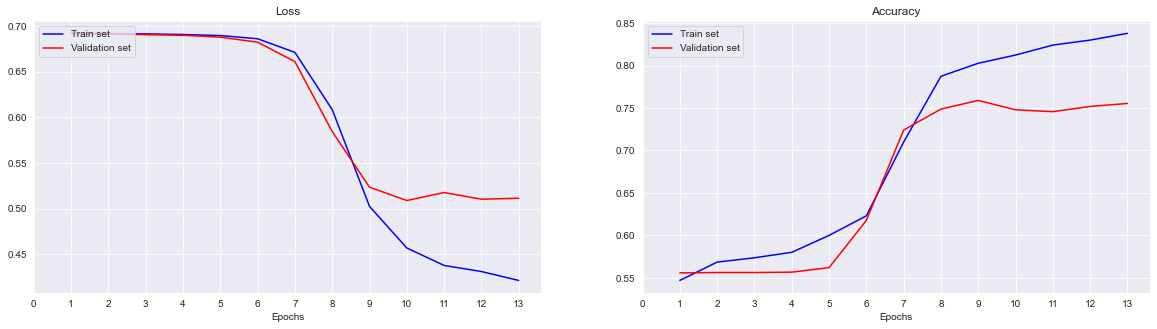

In [22]:
LSTM_history = json.load(open('models/LSTM_history.json', 'r'))
plot_history(LSTM_history)

LSTM

# LSTM enhancement
## Model

In [211]:
model_lstm_2 = tf.keras.Sequential([
                  Embedding(vocab_size, 32, input_shape=[tweet.shape[1],],name="embedding"),
                  SpatialDropout1D(0.3),
                  Bidirectional(LSTM(units=16, return_sequences=False, dropout=0.3)), # returns the last output
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])

In [212]:
model_lstm_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            32000     
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 18, 32)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 38,545
Trainable params: 38,545
Non-trai

In [25]:
optimizer= tf.keras.optimizers.Adam(0.0001)

model_lstm_2.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_lstm_2.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es_callback], class_weight=weights)

Epoch 1/20


2022-11-17 14:56:21.843524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:56:22.092897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:56:22.103196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:56:22.250714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:56:22.265640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4284

2022-11-17 14:56:24.581593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:56:24.661826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 14:56:24.669132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 4s 51ms/step - loss: 0.6934 - accuracy: 0.4284 - val_loss: 0.6945 - val_accuracy: 0.4371
Epoch 2/20
53/53 [==============================] - 1s 28ms/step - loss: 0.6916 - accuracy: 0.5008 - val_loss: 0.6927 - val_accuracy: 0.5258
Epoch 3/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6902 - accuracy: 0.5674 - val_loss: 0.6907 - val_accuracy: 0.6238
Epoch 4/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6874 - accuracy: 0.6378 - val_loss: 0.6879 - val_accuracy: 0.6499
Epoch 5/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6833 - accuracy: 0.6747 - val_loss: 0.6831 - val_accuracy: 0.6834
Epoch 6/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6765 - accuracy: 0.7120 - val_loss: 0.6759 - val_accuracy: 0.6945
Epoch 7/20
53/53 [==============================] - 1s 25ms/step - loss: 0.6667 - accuracy: 0.7160 - val_loss: 0.6658 - val_accuracy: 0.7046
Epoch 8/20
53/53 [======

In [31]:
model_lstm_2.save('models/model_LSTM_final.h5')
json.dump(model_lstm_2.history.history, open('models/LSTM_final_history.json', 'w'))

## Evaluation

Tweeaking our model allowed us to slighty fight the overfitting of our model. It is still not perfect but it is better. The strategy was:
- Adding a SpatialDropOut before the LSTM layer. It is a regularization method that dropouts entire feature maps from the convolutional layer
- Using a bidirectional LSTM layer. "It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second." [source](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

### Loss and accuracy

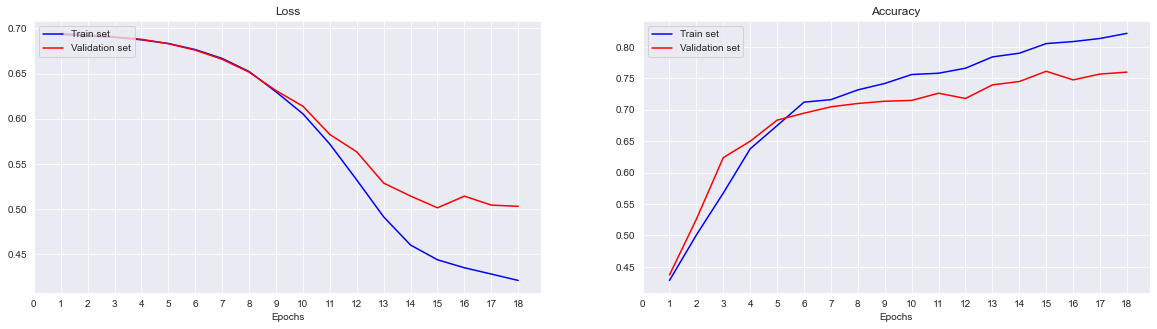

In [28]:
LSTM_history = json.load(open('models/LSTM_final_history.json', 'r'))
plot_history(LSTM_history)

### Confusion matrix

The confusion matrix shows us that our model performs equally on both classes. It does not make better prediction on one of the classe.

In [60]:
model = tf.keras.models.load_model('models/model_LSTM_final.h5')

In [102]:
X_val = np.array([list(data.numpy()) for data, _ in val_data_batch.unbatch()])
y_val = [target.numpy() for _, target in val_data_batch.unbatch()]

In [120]:
y_pred_proba = model.predict(X_val)
y_pred = [1 if proba>0.5 else 0 for proba in y_pred_proba]

71/71 [==============================] - 1s 7ms/step


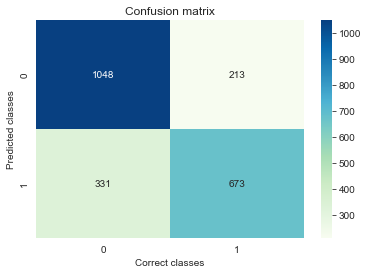

In [134]:
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap = 'GnBu')
ax.set(title='Confusion matrix', xlabel='Correct classes', ylabel='Predicted classes');

# Prediction

In [138]:
text_pad_test = tf.keras.preprocessing.sequence.pad_sequences(test['text_encoded'], padding="post", maxlen=tweet.shape[1])
test['prediction'] = model.predict(text_pad_test)
test['target'] = test['prediction'].apply(lambda x: 1 if x>0.5 else 0)

102/102 [==============================] - 1s 7ms/step


In [141]:
test.head()

,id,keyword,location,text,text_clean,text_encoded,prediction,target
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,"[171, 45, 14]",0.804732,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[127, 169, 935, 119, 367]",0.930391,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[117, 2, 520, 379, 95]",0.897840,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[385, 69]",0.576727,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[391, 522, 11, 337, 939]",0.943969,1


In [144]:
test[['id', 'target']].to_csv('submission/submission.csv', index=False)